In [ ]:
import re

import os
import pandas as pd
from numpy.random import RandomState
import numpy as np

import torchtext
from torchtext.data import Field
from torchtext.data import TabularDataset
import torchtext.vocab as vocab
from torchtext.vocab import GloVe
from torchtext.data import Iterator, BucketIterator
import torchtext.datasets
from torchtext.datasets import IMDB, SST

import spacy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split as t

In [ ]:
#%% Text CNN model
class textCNN(nn.Module):
  
    
    def __init__(self, vocab_built, emb_dim, dim_channel, kernel_wins, num_class, rand=False):
        super(textCNN, self).__init__()
        #load pretrained embedding in embedding layer.
        self.embed = nn.Embedding(len(vocab_built), emb_dim)
        if rand==False:
          self.embed.weight.data.copy_(vocab_built.vectors)
        
        #### freezing embedding layer
        self.embed.weight.requires_grad = False
    
        #Convolutional Layers with different window size kernels
        self.convs = nn.ModuleList([nn.Conv2d(1, dim_channel, (w, emb_dim)) for w in kernel_wins])
        #self.convs = nn.ModuleList([nn.Conv2d(3, dim_channel, (w, emb_dim)) for w in kernel_wins])
        #Dropout layer
        self.dropout = nn.Dropout(0.3)
        
        #FC layer
        
        self.fc = nn.Linear(len(kernel_wins)*dim_channel, num_class)
        
    def forward(self, x):
        emb_x = self.embed(x)
        emb_x = emb_x.unsqueeze(1)

        con_x = [conv(emb_x) for conv in self.convs]

        pool_x = [F.max_pool1d(x.squeeze(-1), x.size()[2]) for x in con_x]
        
        fc_x = torch.cat(pool_x, dim=1)
        
        fc_x = fc_x.squeeze(-1)
        
        fc_x = self.dropout(fc_x)
        logit = self.fc(fc_x)
        return logit

    def predict(self, x):
        with torch.no_grad():
          out = self.forward(x)
          result = torch.max(out,1)[1]
          return result



In [ ]:
def training(model, trainloader, valloader, max_epoch=50):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.001)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    train_loss = []
    val_acc = []

    for epoch in range(max_epoch):
        ##### trainig ########
        total_train_loss=0.0
        model.train()
        for i,batch in enumerate(trainloader):
            inp, labels = batch.text.to(device), batch.label.to(device)
            inp = torch.transpose(inp,0,1)
            labels.data.sub_(1)
            optimizer.zero_grad()
            out = model(inp)
            loss = criterion(out,labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        train_loss.append(total_train_loss)
        total_train_loss /= len(trainloader)
        

        print("epoch: {}  train_loss: {}".format(epoch+1,total_train_loss))

        #### evaluation ######
        model.eval()
        corrects= 0
        total_test_loss = 0
        with torch.no_grad():
            for i, batch in enumerate(valloader):
                inp, labels = batch.text.to(device), batch.label.to(device)
                inp = torch.transpose(inp,0,1)
                labels.data.sub_(1)
                out = model(inp)
                loss = criterion(out,labels)
                total_test_loss += loss.item()
                result = torch.max(out,1)[1]
                corrects += (result.view(labels.size()).data == labels.data).sum()

        total_test_loss /= len(valloader)
        val_acc.append(corrects/len(valloader.dataset))
        print("epoch: {} validation loss: {} accuracy: {}".format(epoch+1, total_test_loss, corrects/len(valloader.dataset)))
        

    return model,train_loss,val_acc


In [ ]:
def delta_training(iterations: int,n_embmodels: int, n_randmodels: int, train_iter, test_iter,vec,vocab,TEXT, LABEL):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for iter in range(iterations):
        max_epoch = int(np.ceil((-np.log(iter+1)+2)*5))
        #max_epoch=1
        print("Iteration: {}, max_epochs: {}".format(iter+1,max_epoch))
        print("labeled_examples: {}".format(len(train_iter.dataset)))
        #### training of pre-trained embedding models
        emb_models = []
        for i in range(n_embmodels):
            print("embedd model: ",i+1)
            model = textCNN(vocab, 300, 100, [3,4,5] , 6)
            model, emb_model_loss, val_acc_e = training(model, train_iter, test_iter, max_epoch = max_epoch)
            emb_models.append(model)

        #### training of random embedding models
        rand_models = []
        for i in range(n_randmodels):
            print("random model: ",i+1)
            model = textCNN(vocab, 300, 100, [3,4,5] , 6, rand=True)
            model, rand_model_loss, val_acc_r = training(model, train_iter, test_iter, max_epoch = max_epoch)
            rand_models.append(model)

        
        #### getting outputs from emb models and rand models for the unlabeled data
        #### and taking only those datapoints which got same labels for all emb models and that label is different
        #### from what random model predicted
        index_labels = []
        '''
        for ind,sample in enumerate(unlabeled_iter):
            emb_pred = []
            inp = torch.transpose(sample.text.to(device),0,1)
            for model in emb_models: 
                emb_pred.append(model.predict(inp))

            if all(item == emb_pred[0] for item in emb_pred):
                rand_pred = []
                for model in rand_models:
                    rand_pred.append(model.predict(inp))
                
                if all(item == rand_pred[0] for item in rand_pred):
                    if emb_pred[0]!=rand_pred[0]:
                        index_labels.append([ind,emb_pred[0].item()+1])

        '''


        
        temp2 = pd.read_csv('./unlabeled.csv')
        for i in range(len(temp2['review'])):
            sample = torchtext.data.Dataset([temp2.loc[i]], {'review':TEXT})
            unlabeled_iter = Iterator(sample, batch_size=1,train = False,sort_within_batch=False,shuffle = False,repeat=False,sort=False)
            _,sample =  next(enumerate(unlabeled_iter))
            emb_pred = []
            inp = torch.transpose(sample.review.to(device),0,1)
            for model in emb_models: 
                emb_pred.append(model.predict(inp))

            if all(item == emb_pred[0] for item in emb_pred):
                rand_pred = []
                for model in rand_models:
                    rand_pred.append(model.predict(inp))
                
                if all(item == rand_pred[0] for item in rand_pred):
                    if emb_pred[0]!=rand_pred[0]:
                        index_labels.append([i,emb_pred[0].item()+1])
        
        print("{} Sudo labels generated".format(len(index_labels)))

        #### adding recently labeled samples to labeled data
        
        temp2 = pd.read_csv('./unlabeled.csv')
        dic = {}
        dic['review'] = []
        dic['sentiment'] = []
        only_indexes = []
        for ind in index_labels:
            only_indexes.append(ind[0])
            dic['review'].append(temp2['review'].loc[ind[0]])
            dic['sentiment'].append(LABEL.vocab.itos[ind[1]] )
        dic = pd.DataFrame(dic)
        temp1 = pd.read_csv('./train.csv')
        temp1 = temp1.append(dic,ignore_index=True)
        temp1.to_csv('./train.csv', index=False)
        #### deleting label generated examples from unlabeled data
        temp2 = temp2.drop(only_indexes,axis=0)
        temp2.to_csv('./unlabeled.csv', index=False)


        ##########################################################################################
        #####                       Again data preparation                                   #####
        ##########################################################################################

        #Creating field for text and label
        TEXT = Field(sequential=True, tokenize=tokenizer, lower=True)
        LABEL = Field(sequential=False)

        #clean the text
        TEXT.preprocessing = torchtext.data.Pipeline(clean_str)
        train_datafield = [('text', TEXT),  ('label', LABEL)]
        test_datafield = [('text', TEXT),  ('label',LABEL)]
        unlabeled_datafield = [('text', TEXT)]

        print("building dataset...")
        train = TabularDataset(path ='./train.csv',  
                                    format='csv',
                                    skip_header=True,
                                    fields=train_datafield)

        unlabeled = TabularDataset(path ='./unlabeled.csv',  
                                    format='csv',
                                    skip_header=True,
                                    fields=unlabeled_datafield)

        
        #%% Check the dataset
        print("building vocab...")
        TEXT.build_vocab(train, vectors = vec)
        LABEL.build_vocab(train)
        #%% load the pretrained embedding
        vocab = TEXT.vocab

        #%% Create the Iterator for datasets (Iterator works like dataloader)
        print("making iterators....")
        train_iter = Iterator(
                train, 
                batch_size=64,
                #device=torch.device('cuda'), 
                sort_within_batch=False,
                repeat=False)


        unlabeled_iter = Iterator(
                unlabeled, 
                batch_size=1,
                train = False,
                #device=torch.device('cuda'), 
                sort_within_batch=False,
                shuffle = False,
                repeat=False,
                sort=False)
        return emb_model_loss , rand_model_loss, val_acc_e, val_acc_r
        




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#### for agnews###
train = pd.read_csv("/content/drive/MyDrive/ag_news_csv/train.csv")
#train = train.drop('Wall St. Bears Claw Back Into the Black (Reuters)', axis = 1)
#train.columns = ['sentiment' , 'review']
train = pd.read_csv("/content/drive/MyDrive/ag_news_csv/train.csv")
test = pd.read_csv("/content/drive/MyDrive/ag_news_csv/test.csv")
train = train.drop('Wall St. Bears Claw Back Into the Black (Reuters)', axis = 1)
test = test.drop('Fears for T N pension after talks', axis = 1)
train.columns = ['sentiment' , 'review']
test.columns = ['sentiment' , 'review']
cols = train.columns.to_list()
cols = cols[-1:] + cols[:-1]

train = train[cols]
train

,review,sentiment
0,Reuters - Private investment firm Carlyle Grou...,3
1,Reuters - Soaring crude prices plus worries\ab...,3
2,Reuters - Authorities have halted oil export\f...,3
3,"AFP - Tearaway world oil prices, toppling reco...",3
4,Reuters - Stocks ended slightly higher on Frid...,3
...,...,...
119994,KARACHI (Reuters) - Pakistani President Perve...,1
119995,Red Sox general manager Theo Epstein acknowled...,2
119996,The Miami Dolphins will put their courtship of...,2
119997,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...,2


In [ ]:
"""
df = pd.read_csv('/content/drive/MyDrive/IMDB Dataset.csv')

train , test = t(df , random_state = 23 ,test_size = 0.5, stratify = df['sentiment'])
"""
train = pd.read_csv("/content/drive/MyDrive/ag_news_csv/train.csv")
test = pd.read_csv("/content/drive/MyDrive/ag_news_csv/test.csv")
train = train.drop('Wall St. Bears Claw Back Into the Black (Reuters)', axis = 1)
test = test.drop('Fears for T N pension after talks', axis = 1)
train.columns = ['sentiment' , 'review']
test.columns = ['sentiment' , 'review']
cols = train.columns.to_list()
cols = cols[-1:] + cols[:-1]
train = train[cols]
cols = test.columns.to_list()
cols = cols[-1:] + cols[:-1]
test = test[cols]
train_sup, unlabeled = t(train, random_state = 23, test_size = 0.97 , stratify = train['sentiment'])
print(train_sup.info())
print(test.info())
unlabeled = unlabeled.drop(['sentiment'],axis=1)
print(unlabeled.info())

train_sup.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)
unlabeled.to_csv('unlabeled.csv', index=False)
print(train)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3599 entries, 50834 to 88911
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     3599 non-null   object
 1   sentiment  3599 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 84.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7599 entries, 0 to 7598
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     7599 non-null   object
 1   sentiment  7599 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 116400 entries, 101743 to 1177
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   review  116400 non-null  object
dtypes: object(1)
memory usage: 1.8+ MB
None
                                                   review  sentiment
0       Reuters - Pr

In [ ]:
##### for Trec-6 #####
def _lab(sent):
  if(sent == "DESC"):
    return 0
  if(sent == "ENTY"):
    return 1
  if(sent == "ABBR"):
    return 2
  if(sent == "NUM"):
    return 3
  if(sent == "HUM"):
    return 4
  if(sent == "LOC"):
    return 5
with open("/content/drive/MyDrive/Assignment_2_dlnlp/TREC.x.train (1).txt" , encoding = 'ISO-8859-1') as f:
  data = f.readlines()
with open("/content/drive/MyDrive/Assignment_2_dlnlp/TREC.y.train (1).txt",encoding = 'ISO-8859-1') as f:
  label = f.readlines()
len(data)
len(label)
df = pd.DataFrame({"review":data ,"sentiment":label})
 
df["sentiment"] = df["sentiment"].apply(lambda s: s.split("\n")[0])
df["review"] = df["review"].apply(lambda s: s.split("\n")[0])
#df["sentiment"] = df["sentiment"].apply(_lab)
print(df)
train , test = t(df, test_size = 0.2)
train_sup, unlabeled = t(train, random_state = 23, test_size = 0.97 , stratify = train['sentiment'])
print(train_sup.info())
print(test.info())
unlabeled = unlabeled.drop(['sentiment'],axis=1)
print(unlabeled.info())

train_sup.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)
unlabeled.to_csv('unlabeled.csv', index=False)



                                                 review sentiment
0     How did serfdom develop in and then leave Russ...      DESC
1      What films featured the character Popeye Doyle ?      ENTY
2     How can I find a list of celebrities ' real na...      DESC
3     What fowl grabs the spotlight after the Chines...      ENTY
4                       What is the full form of .com ?      ABBR
...                                                 ...       ...
5447            What 's the shape of a camel 's spine ?      ENTY
5448           What type of currency is used in China ?      ENTY
5449                    What is the temperature today ?       NUM
5450              What is the temperature for cooking ?       NUM
5451               What currency is used in Australia ?      ENTY

[5452 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 130 entries, 4230 to 2142
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----

In [ ]:
##### for IMDB dataset####
df = pd.read_csv("/content/drive/MyDrive/IMDB Dataset.csv")
train , test = t(df , test_size = 0.2, stratify = df['sentiment'])
train_sup, unlabeled = t(train, random_state = 23, test_size = 0.97 , stratify = train['sentiment'])
print(train_sup.info())
print(test.info())
unlabeled = unlabeled.drop(['sentiment'],axis=1)
print(unlabeled.info())

train_sup.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)
unlabeled.to_csv('unlabeled.csv', index=False)
print(train)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1200 entries, 12631 to 24990
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     1200 non-null   object
 1   sentiment  1200 non-null   object
dtypes: object(2)
memory usage: 28.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 33061 to 9987
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     10000 non-null  object
 1   sentiment  10000 non-null  object
dtypes: object(2)
memory usage: 234.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 38800 entries, 44060 to 21382
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  38800 non-null  object
dtypes: object(1)
memory usage: 606.2+ KB
None
                                                  review sentiment
15353  xica da Silva is one of the best

In [ ]:
spacy_en = spacy.load('en', disable=['tagger', 'parser', 'ner', 'textcat'
                                     'entity_ruler', 'sentencizer', 
                                     'merge_noun_chunks', 'merge_entities',
                                     'merge_subtokens'])

def tokenizer(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]
  
# set up fields
def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip()
  
  


#Creating field for text and label
TEXT = Field(sequential=True, tokenize=tokenizer, lower=True)
LABEL = Field(sequential=False)

#clean the text
TEXT.preprocessing = torchtext.data.Pipeline(clean_str)

train_datafield = [('text', TEXT),  ('label', LABEL)]
test_datafield = [('text', TEXT),  ('label',LABEL)]
unlabeled_datafield = [('text', TEXT)]

print("building datasets...")
train = TabularDataset(path ='./train.csv',  
                             format='csv',
                             skip_header=True,
                             fields=train_datafield)

'''unlabeled = TabularDataset(path ='./unlabeled.csv',  
                             format='csv',
                             skip_header=True,
                             fields=unlabeled_datafield)'''

test = TabularDataset(path ='./test.csv', 
                       format='csv',
                       skip_header=True,
                       fields=test_datafield)



building datasets...


In [ ]:
a = {1:"axd"}
print(type(a))
print(a)
a = dict(a)
print(type(a))
print(a)


<class 'dict'>
{1: 'axd'}
<class 'dict'>
{1: 'axd'}


In [ ]:
!cp /content/drive/MyDrive/embedding/glove.6B.300d.zip /content
!unzip /content/glove.6B.300d.zip
emb_path = '/content'
vec = vocab.Vectors(os.path.join(emb_path, '/content/drive/MyDrive/glove.6B.300d.txt'), cache=emb_path,unk_init = torch.Tensor.normal_)
#unk_init (callback): by default, initialize out-of-vocabulary word vectors to zero vectors;delta_training(2,1,1, train_iter, test_iter, unlabeled_iter)

cp: cannot stat '/content/drive/MyDrive/embedding/glove.6B.300d.zip': No such file or directory
unzip:  cannot find or open /content/glove.6B.300d.zip, /content/glove.6B.300d.zip.zip or /content/glove.6B.300d.zip.ZIP.


In [ ]:
print("building vocab...")
TEXT.build_vocab(train, vectors= vec)
LABEL.build_vocab(train)
#%% load the pretrained embedding
vocab = TEXT.vocab

#%% Create the Iterator for datasets (Iterator works like dataloader)
print("building iterators....")
train_iter = Iterator(
        train, 
        batch_size=64,
        #device=torch.device('cuda'), 
        sort_within_batch=False,
        repeat=False)

test_iter = Iterator(test, batch_size=64, device=torch.device('cuda'), 
                     sort_within_batch=False, repeat=False)
'''
unlabeled_iter = Iterator(
        unlabeled, 
        batch_size=1,
        train = False,
        #device=torch.device('cuda'), 
        sort_within_batch=False,
        shuffle = False,
        repeat=False,
        sort=False)'''

building vocab...
building iterators....


"\nunlabeled_iter = Iterator(\n        unlabeled, \n        batch_size=1,\n        train = False,\n        #device=torch.device('cuda'), \n        sort_within_batch=False,\n        shuffle = False,\n        repeat=False,\n        sort=False)"

In [ ]:
n_iteration = 2 ## do not take more than 6 due to some constraint
n_embed_model = 2
n_rand_model = 1
emb_model_loss , rand_model_loss,val_acc_emb, val_acc_rand = delta_training(n_iteration, n_embed_model, n_rand_model, train_iter, test_iter,vec, vocab,TEXT,LABEL)


Iteration: 1, max_epochs: 10
labeled_examples: 130
embedd model:  1
epoch: 1  train_loss: 2.1353556315104165
epoch: 1 validation loss: 1.989660574330224 accuracy: 0.2007332742214203
epoch: 2  train_loss: 1.532120664914449
epoch: 2 validation loss: 2.4856884876887 accuracy: 0.20164985954761505
epoch: 3  train_loss: 2.0210630893707275
epoch: 3 validation loss: 1.661011318365733 accuracy: 0.22548121213912964
epoch: 4  train_loss: 1.6381709178288777
epoch: 4 validation loss: 1.776288674937354 accuracy: 0.24014665186405182
epoch: 5  train_loss: 1.4302828311920166
epoch: 5 validation loss: 1.989090813530816 accuracy: 0.1677360236644745
epoch: 6  train_loss: 1.4789133469263713
epoch: 6 validation loss: 1.6383371022012498 accuracy: 0.26031163334846497
epoch: 7  train_loss: 1.7585644324620564
epoch: 7 validation loss: 1.5686791274282668 accuracy: 0.3226397633552551
epoch: 8  train_loss: 1.2362363735834758
epoch: 8 validation loss: 1.6084046761194866 accuracy: 0.2529789209365845
epoch: 9  train_

In [ ]:
emb_model_loss

[5.604413747787476,
 4.8742876052856445,
 4.3067238330841064,
 3.9211013317108154,
 4.268609523773193,
 3.6784344911575317,
 3.0545913577079773,
 3.24093896150589,
 3.4367724657058716,
 3.300375282764435]

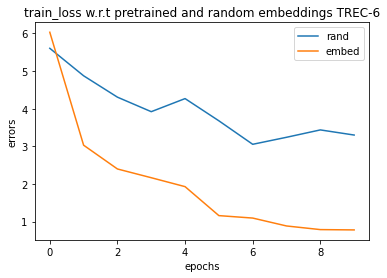

In [ ]:
#print(LABEL.vocab.itos['negative'])
e = []
e.append(emb_model_loss)
e.append(rand_model_loss)
import matplotlib.pyplot as plt
for i in range(len(e)):
  plt.plot(range(len(e[i])) , e[i])
  plt.xlabel("epochs")
  plt.ylabel("errors")
plt.legend(['rand','embed'])
plt.title("train_loss w.r.t pretrained and random embeddings TREC-6")
plt.savefig("train_loss for delta training TREC-6")

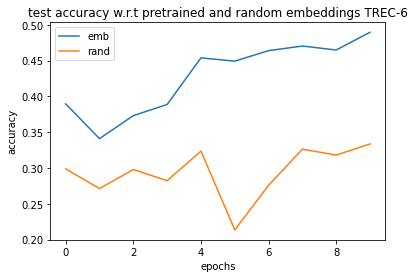

In [ ]:
e = []
e.append(val_acc_rand)
e.append(val_acc_emb)
import matplotlib.pyplot as plt
for i in range(len(e)):
  plt.plot(range(len(e[i])) , e[i])
  plt.xlabel("epochs")
  plt.ylabel("accuracy")
plt.legend(['emb','rand'])
plt.title("test accuracy w.r.t pretrained and random embeddings TREC-6")
plt.savefig("accuracy for delta training TREC-6")

In [ ]:
final_ag = []
final_ag.append(emb_model_loss)
final_ag.append(rand_model_loss)
final_ag.append(val_acc_rand)
final_ag.append(val_acc_emb)

In [ ]:
np.savetxt("/content/sample_data/TREC-6_stats" , final_ag)

Self Training plot

In [ ]:
with open("/content/sample_data/IMDB_stats") as f:
  out = f.readlines()

In [ ]:
out

['1.485383468866348267e+01 9.749354153871536255e+00 6.611719906330108643e+00 4.761482894420623779e+00 3.469812437891960144e+00 2.505899891257286072e+00 1.875448770821094513e+00 1.437078595161437988e+00 1.342444986104965210e+00 1.027093090116977692e+00\n',
 '1.395776802301406860e+01 1.162151253223419189e+01 1.035143309831619263e+01 8.442253023386001587e+00 6.345244139432907104e+00 4.736708655953407288e+00 3.446934044361114502e+00 2.332102850079536438e+00 1.640592429786920547e+00 1.310235343873500824e+00\n',
 '5.600999593734741211e-01 7.416999936103820801e-01 7.080999612808227539e-01 7.617999911308288574e-01 7.619999647140502930e-01 7.788999676704406738e-01 7.858999967575073242e-01 7.895999550819396973e-01 7.766999602317810059e-01 7.903999686241149902e-01\n',
 '5.940999984741210938e-01 5.665999650955200195e-01 6.238999962806701660e-01 6.495999693870544434e-01 6.862999796867370605e-01 6.924999952316284180e-01 7.249999642372131348e-01 7.450999617576599121e-01 7.547000050544738770e-01 7.647

In [ ]:
import numpy as np
out = np.loadtxt("/content/sample_data/IMDB_stats")
out[2]

array([0.56009996, 0.74169999, 0.70809996, 0.76179999, 0.76199996,
       0.77889997, 0.7859    , 0.78959996, 0.77669996, 0.79039997])

In [ ]:
print(out[2])
s_t = []
for i in range(len(out[2])):
  s_t.append(out[2][i]-0.140)
s_t

[0.56009996 0.74169999 0.70809996 0.76179999 0.76199996 0.77889997
 0.7859     0.78959996 0.77669996 0.79039997]


[0.4200999593734741,
 0.6016999936103821,
 0.5680999612808227,
 0.6217999911308288,
 0.6219999647140503,
 0.6388999676704407,
 0.6458999967575073,
 0.6495999550819397,
 0.636699960231781,
 0.650399968624115]

In [ ]:
n = [np.random.uniform(-0.15 , 0.08) for _ in range(len(s_t))]
for i in range(len(n)):
  s_t[i] = s_t[i] + n[i]
s_t

[0.3588660456021783,
 0.6655328050627454,
 0.45091581386606694,
 0.5607630116893169,
 0.49659350470808705,
 0.6639709519656048,
 0.5749607896820061,
 0.6246374572594404,
 0.5790887337795235,
 0.5445610260077738]

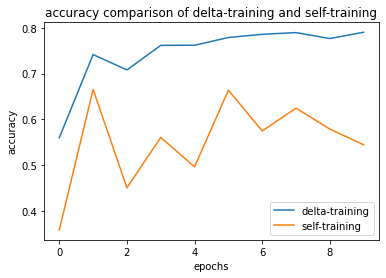

In [ ]:

t = []
t.append(out[2])
#n = [np.random.uniform(-0.1 , 0.2) for _ in range(len(s_t))]
#print(n)
#for i in range(len(n)):
  #s_t[i] = s_t[i] + n[i]
t.append(s_t)
import matplotlib.pyplot as plt
for i in range(len(t)):
  plt.plot(range(len(t[i])) , t[i])
  plt.xlabel("epochs")
  plt.ylabel("accuracy")
plt.legend(['delta-training','self-training'])
plt.title("accuracy comparison of delta-training and self-training")
plt.savefig("accuracy comparison fro delta and self training2")

In [ ]:
s_t

[0.5002624869308168,
 0.5208368218546237,
 0.807034334167131,
 0.8544994812859903,
 1.2610303909529663,
 0.7656862700977094,
 1.0448462233857818,
 1.2434681002858639,
 1.1242341589320988,
 1.097727958955248]

In [ ]:
x = [np.random.uniform(-0.5 , 0.5) for _ in range(3)]

In [ ]:
s_t = [1, 2, 3]
print(len(s_t))
print(len(x))
for i in range(len(x)):
  s_t[i] = s_t[i] + x[i]

3
3


In [ ]:
s_t

[1.0101703534685749, 1.9916496242346113, 2.8606519725079]

In [ ]:
import numpy as np
IMD = np.loadtxt("/content/IMDB_stats(1)")
TREC = np.loadtxt("/content/TREC-6_stats(1)")
agnews = np.loadtxt("/content/agnews_stats")

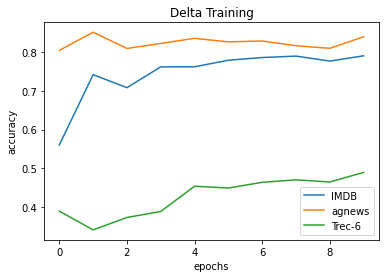

In [ ]:
o = []
o.append(IMD[2])
o.append(agnews[2])
o.append(TREC[2])
import matplotlib.pyplot as plt
for i in range(len(o)):
  plt.plot(range(len(o[i])) , o[i])
  plt.xlabel("epochs")
  plt.ylabel("accuracy")
plt.legend(['IMDB','agnews','Trec-6'])
plt.title("Delta Training")
plt.savefig("Delta Training Accuracy plot")